In [128]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from skimage.io import imread, imshow
from skimage.measure import find_contours
from pydicom import dcmread
import nibabel as nib
import pyvista as pv
from IPython.display import HTML
import joblib
import pycpd
from ipywidgets import interact

In [129]:
def cycle_plot(imgs, delay=400, axis=0, marker=None):
    if axis != 0:
        imgs = np.moveaxis(imgs, axis, 0)

    fig, ax = plt.subplots()

    frames = []
    for i, img in enumerate(imgs):
        content = []

        frame = ax.imshow(img, animated=True, cmap="Greys_r")
        content.append(frame)

        title = ax.text(
            0.5,
            1.02,
            str(i),
            ha="center",
            va="bottom",
            transform=ax.transAxes,
            fontsize="large",
        )

        content.append(title)

        if marker:
            m = ax.scatter(*marker, c="red")
            content.append(frame)

        frames.append(content)

    plt.close()
    ani = animation.ArtistAnimation(fig, frames, interval=delay, blit=True)
    return HTML(ani.to_html5_video())

In [147]:
basepath = "/mnt/materials/SIRF/MathPlusBerlin/DATA/ACDC-Daten/DCM"
patient = "patient004"
img_path = os.path.join(basepath, patient, "image.nii.gz")
label_path = os.path.join(basepath, patient, "label.nii.gz")

In [148]:
img = nib.load(img_path).get_fdata()
label = nib.load(label_path).get_fdata()

In [149]:
label.shape

(232, 256, 10, 1, 28, 1)

In [150]:
# imshow(img[:, :, 5, 0, t, 0])

@interact
def plot(i=(0, label.shape[4] - 1, 1)):
    imshow(img[:, :, 4, 0, i, 0])

interactive(children=(IntSlider(value=13, description='i', max=27), Output()), _dom_classes=('widget-interact'…

In [151]:
@interact
def plot(i=(0, label.shape[4] - 1, 1)):
    imshow(label[:, :, 4, 0, i, 0])

interactive(children=(IntSlider(value=13, description='i', max=27), Output()), _dom_classes=('widget-interact'…

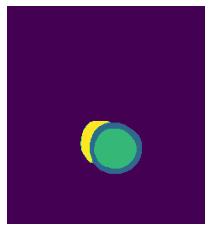

In [178]:
# label_img = np.ma.masked_equal(label[:, :, 4, 0, 5, 0], 0)
label_img = label[:, :, 4, 0, 5, 0]
plt.imshow(label_img.T, origin="lower")
plt.axis("off")
plt.savefig("boundary_recons/label.png")
plt.show()

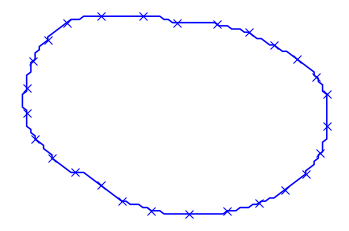

In [180]:
contour = find_contours(label_img > 0)[0]
plt.plot(*contour.T, "bx-", markevery=10, markersize=8)
plt.axis("off")
plt.savefig("boundary_recons/contour.png")

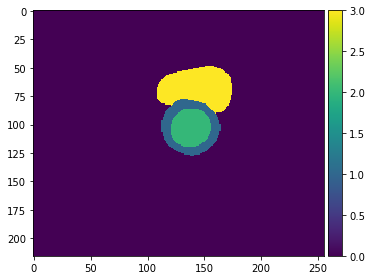

In [33]:
imshow(slc)

### Try with pyvista

For now we decided to use something else since this is for 3d data and plotting crashes the kernel

In [35]:
coords = np.stack(np.nonzero(slc)).astype(float)
coords = np.concatenate((coords, np.zeros((1, coords.shape[1]))))

In [36]:
point_cloud = pv.PolyData(coords.T)

In [37]:
# point_cloud.plot(eye_dome_lighting=True)

### Try scikit image

In [106]:
contours = find_contours(slc > 0)

In [107]:
len(contours)

1

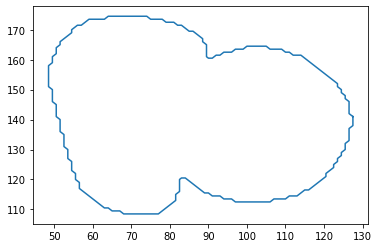

In [108]:
for contour in contours:
    plt.plot(*contour.T)

In [109]:
contours[0].shape

(315, 2)

### Implementation for all slices and time points

In [110]:
def load_labels(patient, basepath="/mnt/materials/SIRF/MathPlusBerlin/DATA/ACDC-Daten/DCM"):
    label_path = os.path.join(basepath, patient, "label.nii.gz")
    return nib.load(label_path).get_fdata()

In [111]:
def extract_contours(label):
    n_slices = label.shape[2]
    slice_idx = n_slices // 2
    n_times = label.shape[4]

    contours = []
    for i in range(n_times):
        contour = find_contours(label[:, :, slice_idx, 0, i, 0] > 0)
            # if len(cnts_slice) == 1:
            #     cnts_time.append(cnts_slice[0])
            # elif len(cnts_slice) > 1:
            #     print(len(cnts_slice))
            #     raise RuntimeError("")
        if contour:
            contours.append(contour[0])
    return contours

In [112]:
patients = [f"patient{i:03d}" for i in range(1, 16)]
contours = {}
for patient in patients:
    print(patient)
    label = load_labels(patient)
    contours[patient] = extract_contours(label)

patient001
patient002
patient003
patient004
patient005
patient006
patient007
patient008
patient009
patient010
patient011
patient012
patient013
patient014
patient015


In [113]:
len(contours["patient001"][0])

263

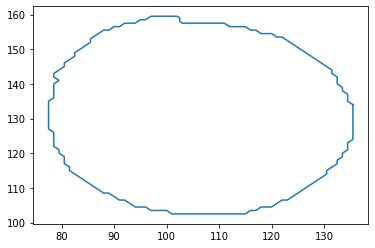

In [114]:
plt.plot(*contours["patient002"][8].T)

In [115]:
joblib.dump(contours, "contours.joblib")

['contours.joblib']

### Alignment

Only works for us with pycpd==1.0.5

In [116]:
def callback(iteration, error, X, Y):
	print('iteration={0}, error={1}'.format(iteration, error))

In [117]:
contours = joblib.load("contours.joblib")

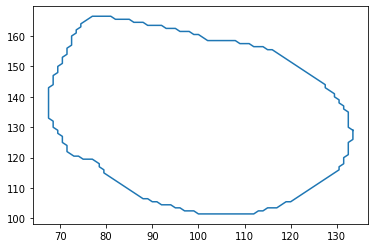

In [118]:
reference = contours["patient001"][0]
# reference = (reference - reference.mean(axis=0)) / reference.std(axis=0)
# reference = np.concatenate((reference, np.zeros((reference.shape[0], 1))), axis=1)
plt.plot(*reference.T)

In [119]:
sample = contours["patient002"][-1]

reg = pycpd.affine_registration(X=sample, Y=reference)
sample_aff, _ = reg.register()

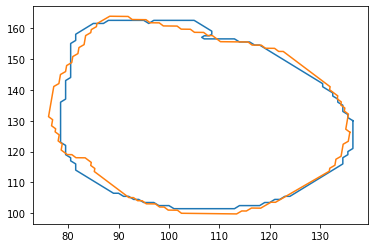

In [120]:
plt.plot(*sample.T)
plt.plot(*sample_aff.T)

In [121]:
reg = pycpd.deformable_registration(X=sample, Y=sample_aff)
sample_reg, _ = reg.register()

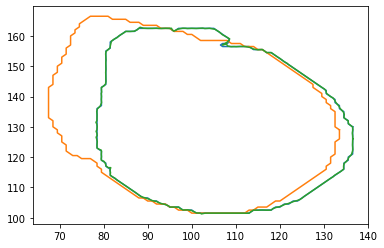

In [122]:
plt.plot(*sample.T)
plt.plot(*reference.T)
plt.plot(*sample_reg.T)

In [123]:
sample = contours["patient002"][0][1]

def register_shape(sample, reference):
    reg = pycpd.affine_registration(X=sample, Y=reference)
    sample_aff, _ = reg.register()

    reg = pycpd.deformable_registration(X=sample, Y=sample_aff)
    sample_reg, _ = reg.register()
    
    return sample_reg

In [124]:
contours_reg = {}
for patient, contours_slice in contours.items():
    print(patient)
    cnts_slice_reg = []
    for sample in contours_slice:
        sample_reg = register_shape(sample, reference)
        cnts_slice_reg.append(sample_reg)
    contours_reg[patient] = cnts_slice_reg

patient001
patient002
patient003
patient004
patient005
patient006
patient007
patient008
patient009
patient010
patient011
patient012
patient013
patient014
patient015


In [125]:
joblib.dump(contours_reg, "contours_registered.joblib")

['contours_registered.joblib']

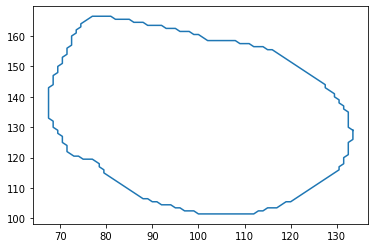

In [126]:
contours = contours_reg["patient001"]
plt.plot(*contours[0].T)

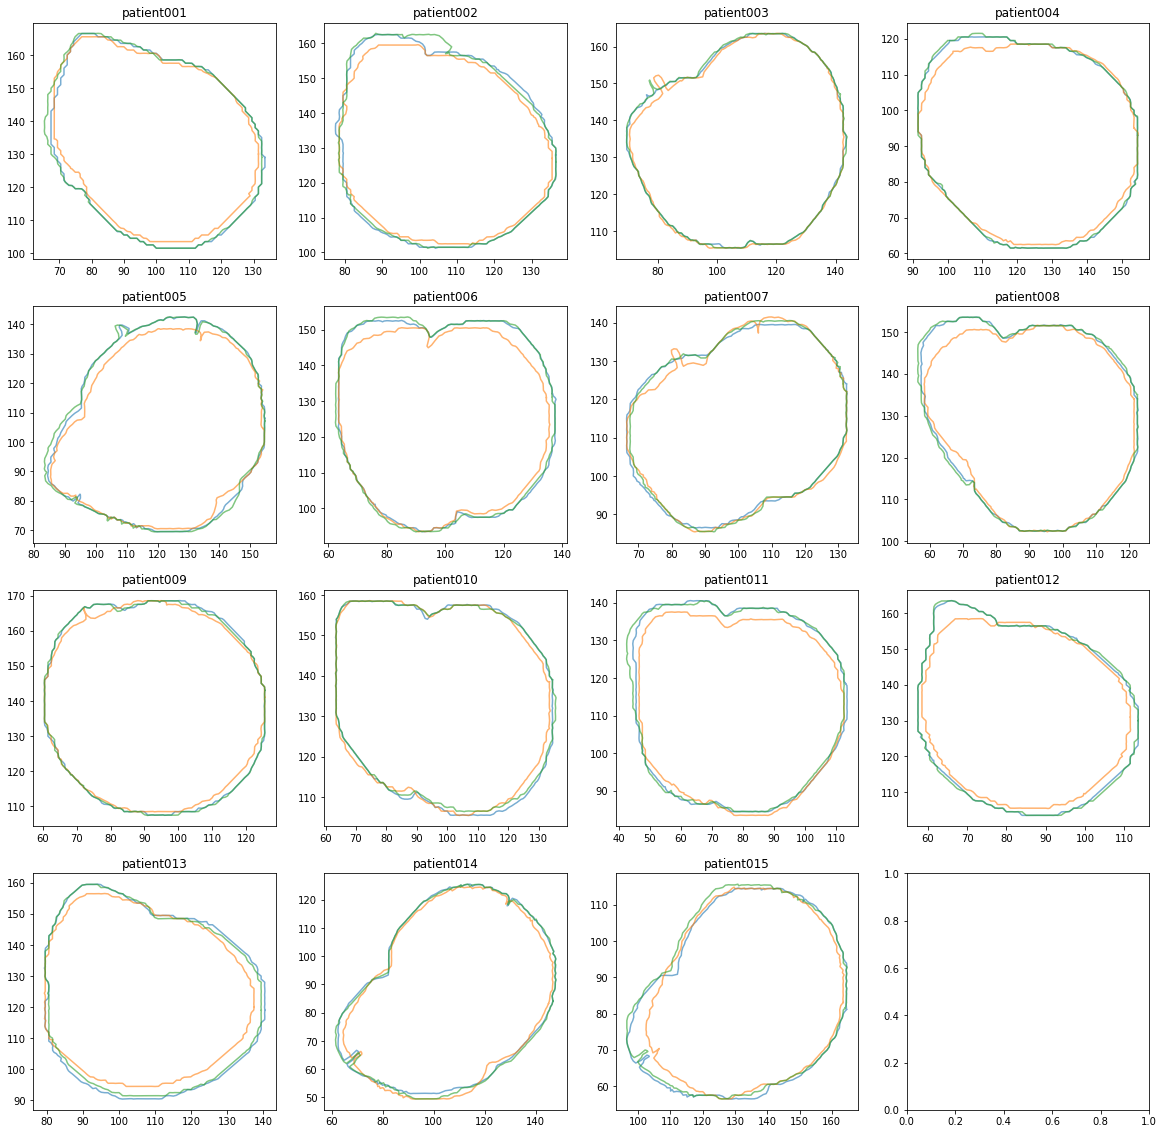

In [127]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

for (patient, contours), ax in zip(contours_reg.items(), axes):
    ax.plot(*contours[0].T, alpha=0.6)
    ax.plot(*contours[len(contours) // 2].T, alpha=0.6)
    ax.plot(*contours[-1].T, alpha=0.6)
    ax.set_title(patient)